In [1]:
%load_ext autoreload
%autoreload 2
from allennlp.commands.evaluate import *
from kb.include_all import *
from allennlp.nn import util as nn_util
from allennlp.common.tqdm import Tqdm
import torch
import warnings
warnings.filterwarnings("ignore")
archive_file = "knowbert_wiki_wordnet_model"
cuda_device = -1
# line = "banana\tcolor\tyellow"

/nas/home/gujiashe/miniconda3/envs/knowbert/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/nas/home/gujiashe/miniconda3/envs/knowbert/lib/python3.6/site-packages/allennlp/data/token_indexers/token_characters_indexer.py:51: UserWarning: You are using the default value (0) of `min_padding_length`, which can cause some subtle bugs (more info see https://github.com/allenai/allennlp/issues/1954). Strongly recommend to set a value, usually the maximum size of the convolutional layer size when using CnnEncoder.
  UserWarning)


In [2]:
import logging

logger = logging.getLogger()  # 不加名称设置root logger
logger.setLevel(logging.INFO)
formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s: - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')

# 使用FileHandler输出到文件
fh = logging.FileHandler('log.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

# 使用StreamHandler输出到屏幕
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)

# 添加两个Handler
logger.addHandler(ch)
logger.addHandler(fh)

In [3]:
archive = load_archive(archive_file, cuda_device)
config = archive.config
prepare_environment(config)

2022-03-19 17:39:24 - allennlp.models.archival - INFO: - loading archive file knowbert_wiki_wordnet_model
2022-03-19 17:39:24 - allennlp.common.params - INFO: - vocabulary.type = default
2022-03-19 17:39:24 - allennlp.data.vocabulary - INFO: - Loading token dictionary from knowbert_wiki_wordnet_model/vocabulary.
2022-03-19 17:39:25 - allennlp.common.from_params - INFO: - instantiating class <class 'allennlp.models.model.Model'> from params {'bert_model_name': 'bert-base-uncased', 'soldered_kgs': {'wiki': {'entity_linker': {'contextual_embedding_dim': 768, 'entity_embedding': {'embedding_dim': 300, 'sparse': False, 'trainable': False, 'vocab_namespace': 'entity_wiki'}, 'namespace': 'entity_wiki', 'span_encoder_config': {'hidden_size': 300, 'intermediate_size': 1024, 'num_attention_heads': 4, 'num_hidden_layers': 1}, 'type': 'entity_linking_with_candidate_mentions'}, 'should_init_kg_to_bert_inverse': False, 'span_attention_config': {'hidden_size': 300, 'intermediate_size': 1024, 'num_att

2022-03-19 17:39:26 - allennlp.common.params - INFO: - model.soldered_kgs.wiki.entity_linker.decode_threshold = 0.0
2022-03-19 17:39:26 - allennlp.common.params - INFO: - model.soldered_kgs.wiki.entity_linker.loss_type = margin
2022-03-19 17:39:26 - allennlp.common.params - INFO: - model.soldered_kgs.wiki.entity_linker.max_sequence_length = 512
2022-03-19 17:39:26 - allennlp.common.params - INFO: - model.soldered_kgs.wiki.entity_linker.dropout = 0.1
2022-03-19 17:39:26 - allennlp.common.params - INFO: - model.soldered_kgs.wiki.entity_linker.output_feed_forward_hidden_dim = 100
2022-03-19 17:39:26 - allennlp.common.params - INFO: - model.soldered_kgs.wiki.entity_linker.initializer_range = 0.02
2022-03-19 17:39:26 - allennlp.common.params - INFO: - model.soldered_kgs.wiki.entity_linker.include_null_embedding_in_dot_attention = False
2022-03-19 17:39:26 - allennlp.common.params - INFO: - model.soldered_kgs.wiki.entity_linker.namespace = entity_wiki
2022-03-19 17:39:26 - allennlp.common.pa

2022-03-19 17:39:33 - allennlp.common.params - INFO: - model.soldered_kgs.wordnet.entity_linker.decode_threshold = 0.0
2022-03-19 17:39:33 - allennlp.common.params - INFO: - model.soldered_kgs.wordnet.entity_linker.loss_type = softmax
2022-03-19 17:39:33 - allennlp.common.params - INFO: - model.soldered_kgs.wordnet.entity_linker.max_sequence_length = 512
2022-03-19 17:39:33 - allennlp.common.params - INFO: - model.soldered_kgs.wordnet.entity_linker.dropout = 0.1
2022-03-19 17:39:33 - allennlp.common.params - INFO: - model.soldered_kgs.wordnet.entity_linker.output_feed_forward_hidden_dim = 100
2022-03-19 17:39:33 - allennlp.common.params - INFO: - model.soldered_kgs.wordnet.entity_linker.initializer_range = 0.02
2022-03-19 17:39:33 - allennlp.common.params - INFO: - model.soldered_kgs.wordnet.entity_linker.include_null_embedding_in_dot_attention = False
2022-03-19 17:39:33 - allennlp.common.params - INFO: - model.soldered_kgs.wordnet.entity_linker.namespace = entity_wordnet
2022-03-19 1

In [4]:
config = Params.from_file("/nas/home/gujiashe/kb/knowbert_wiki_wordnet_model/config.json")

In [5]:
reader_params = config.pop('dataset_reader')
if reader_params['type'] == 'multitask_reader':
    reader_params = reader_params['dataset_readers']['language_modeling']
# reader_params['num_workers'] = 0
validation_reader_params = {
    "type": "kg_probe",
    "tokenizer_and_candidate_generator": reader_params['base_reader']['tokenizer_and_candidate_generator'].as_dict()
}
dataset_reader = DatasetReader.from_params(Params(validation_reader_params))

vocab = dataset_reader._tokenizer_and_candidate_generator.bert_tokenizer.vocab
token2word = {}
for k, v in vocab.items():
    token2word[v] = k

2022-03-19 17:39:42 - allennlp.common.params - INFO: - Converting Params object to dict; logging of default values will not occur when dictionary parameters are used subsequently.
2022-03-19 17:39:42 - allennlp.common.params - INFO: - CURRENTLY DEFINED PARAMETERS: 
2022-03-19 17:39:42 - allennlp.common.params - INFO: - dataset_reader.dataset_readers.language_modeling.base_reader.tokenizer_and_candidate_generator.bert_model_type = bert-base-uncased
2022-03-19 17:39:42 - allennlp.common.params - INFO: - dataset_reader.dataset_readers.language_modeling.base_reader.tokenizer_and_candidate_generator.do_lower_case = True
2022-03-19 17:39:42 - allennlp.common.params - INFO: - dataset_reader.dataset_readers.language_modeling.base_reader.tokenizer_and_candidate_generator.entity_candidate_generators.wiki.type = wiki
2022-03-19 17:39:42 - allennlp.common.params - INFO: - dataset_reader.dataset_readers.language_modeling.base_reader.tokenizer_and_candidate_generator.entity_candidate_generators.word

duplicate_mentions_cnt:  6777
end of p_e_m reading. wall time: 1.228600227832794  minutes
p_e_m_errors:  0
incompatible_ent_ids:  0


2022-03-19 17:41:27 - allennlp.common.from_params - INFO: - instantiating class <class 'kb.common.MentionGenerator'> from params {'entity_file': 'https://allennlp.s3-us-west-2.amazonaws.com/knowbert/wordnet/entities.jsonl', 'type': 'wordnet_mention_generator'} and extras set()
2022-03-19 17:41:27 - allennlp.common.params - INFO: - tokenizer_and_candidate_generator.entity_candidate_generators.wordnet.type = wordnet_mention_generator
2022-03-19 17:41:27 - allennlp.common.from_params - INFO: - instantiating class <class 'kb.wordnet.WordNetCandidateMentionGenerator'> from params {'entity_file': 'https://allennlp.s3-us-west-2.amazonaws.com/knowbert/wordnet/entities.jsonl'} and extras set()
2022-03-19 17:41:27 - allennlp.common.params - INFO: - tokenizer_and_candidate_generator.entity_candidate_generators.wordnet.entity_file = https://allennlp.s3-us-west-2.amazonaws.com/knowbert/wordnet/entities.jsonl
2022-03-19 17:41:27 - allennlp.common.params - INFO: - tokenizer_and_candidate_generator.en

In [6]:
instances = dataset_reader.read("/nas/home/gujiashe/kb/sentences_birth.tsv")
print(instances[0])

9168it [00:20, 442.87it/s]

Instance with fields:
 	 tokens: TextField of length 25 with text: 
 		[[CLS], [MASK], [MASK], [MASK], [MASK], [MASK], gave, birth, to, cornelius, tu, ##ayan, ke, ##ago,
		##n, at, mon, ##rov, ##ia, on, 06, july, 1996, ., [SEP]]
 		and TokenIndexers : {'tokens': 'SingleIdTokenIndexer'} 
 	 segment_ids: ArrayField with shape: (25,). 
 	 candidates:  
 	 lm_label_ids: TextField of length 25 with text: 
 		[[CLS], se, ##lina, ke, ##ago, ##n, gave, birth, to, cornelius, tu, ##ayan, ke, ##ago, ##n, at, mon,
		##rov, ##ia, on, 06, july, 1996, ., [SEP]]
 		and TokenIndexers : {'lm_labels': 'SingleIdTokenIndexer'} 
 	 mask_indicator: ArrayField with shape: (25,). 



In [7]:
import pandas as pd
 
birth_df = pd.read_csv('/nas/home/gujiashe/kb/sentences_birth.tsv', sep='\t', header = None)


birth = birth_df.values
print(birth[0])

['0 1'
 'Selina Keagon gave birth to Cornelius Tuayan Keagon at Monrovia on 06 July 1996 .']


In [8]:
instances[0]["lm_label_ids"][2]

##lina

In [17]:
import csv
model = archive.model
model.eval()


print("start")
# metrics = evaluate(model, instances, iterator, cuda_device, "")
data_iterator = DataIterator.from_params(Params(
    {"type": "basic", "batch_size": 1}
))
data_iterator.index_with(model.vocab)
iterator = data_iterator(instances,
                            num_epochs=1,
                            shuffle=False)
logger.info("Iterating over dataset")
generator_tqdm = Tqdm.tqdm(iterator, total=data_iterator.get_num_batches(instances))
rows_id = 0
# with open('birth3.txt', 'wt') as f:
birth_spreadsheet = open("birth_spreadsheet.tsv", "w")
tsv_writer = csv.writer(birth_spreadsheet, delimiter='\t')

total_ranks = []

for instance in generator_tqdm:

    rows_id+=1

    batch = nn_util.move_to_device(instance, cuda_device)
    output_dict = model(**batch)
    pooled_output = output_dict.get("pooled_output")
    contextual_embeddings = output_dict.get("contextual_embeddings")
    prediction_scores, seq_relationship_score = model.pretraining_heads(
    contextual_embeddings, pooled_output
    )
    prediction_scores = prediction_scores.view(-1, prediction_scores.shape[-1])
    

    ranks = torch.argsort(prediction_scores, dim = 1, descending=True)
    ranks = torch.argsort(ranks, dim = 1)
    vals, idxs = torch.topk(prediction_scores, k = 5, dim = 1)
    idxs = idxs.cpu().numpy()
    lines = []
    # print("row: ", rows_id, file=f)
    # print("================", file=f)
    # print("source: ", birth[rows_id - 1, 1], file = f)
    masked_tokens = []
    for id in range(len(idxs)):
        masked_tokens += [token2word[instance["tokens"]["tokens"][0][id].item()]]
    masked_tokens = " ".join(masked_tokens[1: -1])
    masked_ranks = []
    
    for k in range(1):
        source = []
        line = []
        for i, idx in enumerate(idxs):
            if instance["tokens"]["tokens"][0][i] != 103:
                line += [token2word[instance["tokens"]["tokens"][0][i].item()]]
            else:
                line += [token2word[idx[k]]]
                text_id = instance["lm_label_ids"]["lm_labels"][0][i].item()
                masked_ranks += [ranks[i][text_id].item()]
        
        line = " ".join(line[1: -1])
        line = line.split(" ##")
        line = "".join(line)
        total_ranks += masked_ranks
        masked_ranks = list(map(str, masked_ranks))
        masked_ranks = ",".join(masked_ranks)
        # print("{}     :  ".format(k) + line, file=f)
        # print("masked_ranks: ", masked_ranks , file = f)
    # print("masked_tokens: ", masked_tokens, file = f)
    # print("================", file=f)
    row = [birth[rows_id - 1, 1], masked_tokens, line, masked_ranks]
    
    tsv_writer.writerow(row)
#     if rows_id>100:
#         break
birth_spreadsheet.close()


2022-03-19 17:45:52 - allennlp.common.from_params - INFO: - instantiating class <class 'allennlp.data.iterators.data_iterator.DataIterator'> from params {'type': 'basic', 'batch_size': 1} and extras set()
2022-03-19 17:45:52 - allennlp.common.params - INFO: - type = basic
2022-03-19 17:45:52 - allennlp.common.from_params - INFO: - instantiating class <class 'allennlp.data.iterators.basic_iterator.BasicIterator'> from params {'batch_size': 1} and extras set()
2022-03-19 17:45:52 - allennlp.common.params - INFO: - batch_size = 1
2022-03-19 17:45:52 - allennlp.common.params - INFO: - instances_per_epoch = None
2022-03-19 17:45:52 - allennlp.common.params - INFO: - max_instances_in_memory = None
2022-03-19 17:45:52 - allennlp.common.params - INFO: - cache_instances = False
2022-03-19 17:45:52 - allennlp.common.params - INFO: - track_epoch = False
2022-03-19 17:45:52 - allennlp.common.params - INFO: - maximum_samples_per_batch = None
2022-03-19 17:45:52 - root - INFO: - Iterating over datas

start


100%|██████████| 9168/9168 [23:26<00:00,  6.52it/s]


<IPython.core.display.Javascript object>


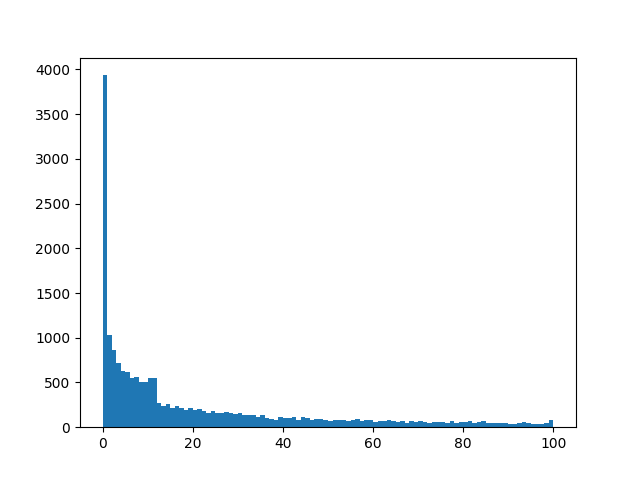

(array([3936., 1036.,  862.,  716.,  628.,  612.,  548.,  562.,  508.,
         509.,  551.,  549.,  270.,  239.,  255.,  214.,  235.,  216.,
         191.,  212.,  189.,  202.,  180.,  158.,  182.,  162.,  157.,
         172.,  164.,  151.,  156.,  131.,  141.,  135.,  116.,  138.,
         105.,   94.,   85.,  112.,  100.,  108.,  117.,   79.,  109.,
         104.,   86.,   94.,   94.,   78.,   67.,   78.,   82.,   81.,
          66.,   79.,   93.,   71.,   75.,   78.,   55.,   74.,   69.,
          75.,   73.,   57.,   74.,   44.,   72.,   63.,   74.,   58.,
          47.,   60.,   55.,   56.,   50.,   66.,   45.,   61.,   54.,
          71.,   52.,   54.,   69.,   44.,   42.,   47.,   45.,   46.,
          39.,   32.,   42.,   57.,   44.,   33.,   41.,   37.,   51.,
          84.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.

In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.hist(total_ranks, bins = 100, range = [0, 100])


In [11]:
plt.scatter([1,2],[3,4])
plt.show()